# Sktime workshop: Pycon Colombia 2025

![](imgs/sktime-logo.png)

## Agenda for today

1. **Univariate timeseries forecasting with sktime** (20 min)
   1. Key concepts in forecasting
   2. Univariate forecasting with statistical models
   3. Metrics and evaluation
2. **Forecasting panel data with sktime** (30 min)
   1. Data representation for panel data
   2. Up-casting feature in sktime
   3. Panel forecasting with global models
3. **Hierarchical forecasting with sktime** (20 min)
   1. Data representation for hierarchical data
   2. Motivation
   3. Hierarchical reconciliation
4. **Deep learning models and Foundation models in sktime** (20 min)
   1. Deep learning models for forecasting
   2. Foundation models for forecasting

# 1. Univariate timeseries forecasting with sktime

* Synthetic dataset of sales of a retail store
* We will first consider the case of univariate forecasting
  * Consider we need to **forecast total sales in a warehouse**
  
* **Objective: get familiar with sktime interface and its versatility**

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Loading the dataset

We first load the dataset without exogenous variables

In [2]:
from pycon_workshop.dataset import PyConWorkshopDataset

dataset = PyConWorkshopDataset()

y_train, y_test = dataset.load("y_train", "y_test")

display(y_train)

,sales
date,
2020-01-01,29
2020-01-02,20
2020-01-03,19
2020-01-04,19
2020-01-05,18
...,...
2024-07-01,2246
2024-07-02,2247
2024-07-03,2191


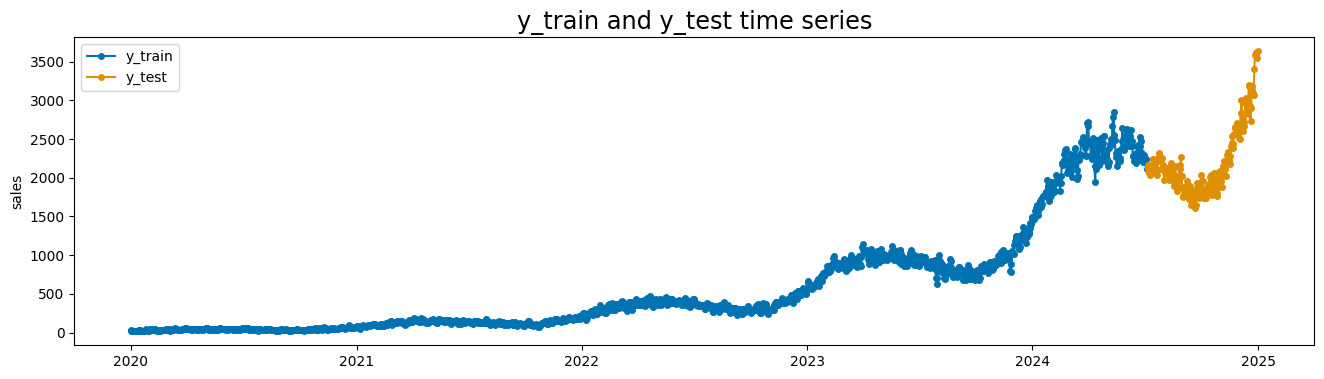

In [3]:
from sktime.utils.plotting import plot_series

plot_series(y_train, y_test, labels=["y_train", "y_test"], title="y_train and y_test time series")
plt.show()

### Basic forecasting API

- `fit(y)`
- `predict(fh=[1,2,3])`


#### Naive model

In [4]:
from sktime.forecasting.naive import NaiveForecaster

model = NaiveForecaster(strategy="drift")
model.fit(y_train)

NaiveForecaster(strategy='drift')

In [5]:
y_pred = model.predict(fh=[1, 2, 3, 4, 5])
y_pred

,sales
2024-07-06,2117.267152
2024-07-07,2118.534305
2024-07-08,2119.801457
2024-07-09,2121.068610
2024-07-10,2122.335762


In [6]:
y_test

,sales
2024-07-06,2125
2024-07-07,2162
2024-07-08,2068
2024-07-09,2062
2024-07-10,2041
...,...
2024-12-28,3616
2024-12-29,3594
2024-12-30,3551
2024-12-31,3621


In [7]:
fh = pd.period_range("2024-10-04", "2025-01-01", freq="D")
y_pred = model.predict(fh=fh)
y_pred

,sales
2024-10-04,2231.310868
2024-10-05,2232.578021
2024-10-06,2233.845173
2024-10-07,2235.112325
2024-10-08,2236.379478
...,...
2024-12-28,2339.018822
2024-12-29,2340.285974
2024-12-30,2341.553127
2024-12-31,2342.820279


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'y_train, y_test and y_pred time series'}, ylabel='sales'>)

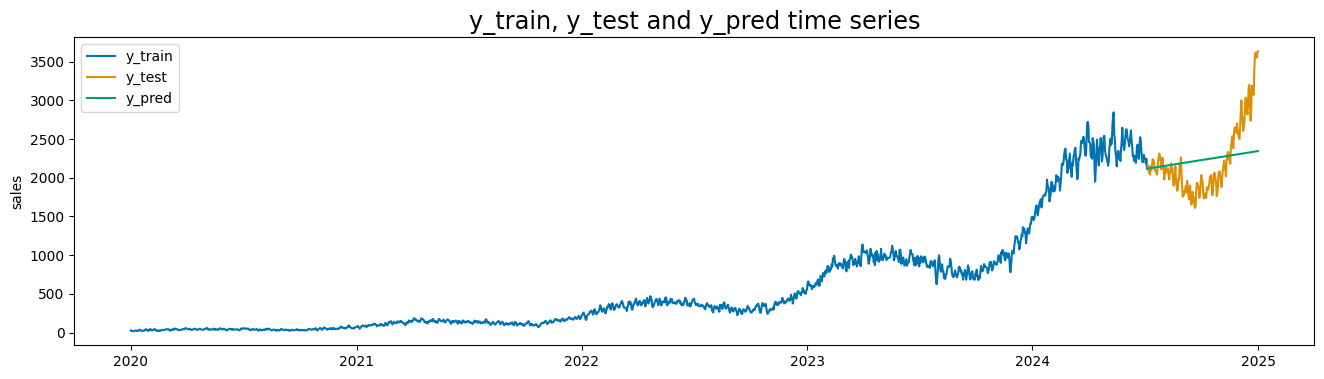

In [8]:
fh = y_test.index
y_pred = model.predict(fh=fh)


plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title="y_train, y_test and y_pred time series",markers=[None]*3)

#### Exponential smoothing

In [9]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

model_exp_smoothing = ExponentialSmoothing(trend="add", seasonal="mul", sp=365)
model_exp_smoothing.fit(y_train)
y_pred_exp_smoothing = model_exp_smoothing.predict(fh=fh)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Exponential Smoothing'}, ylabel='sales'>)

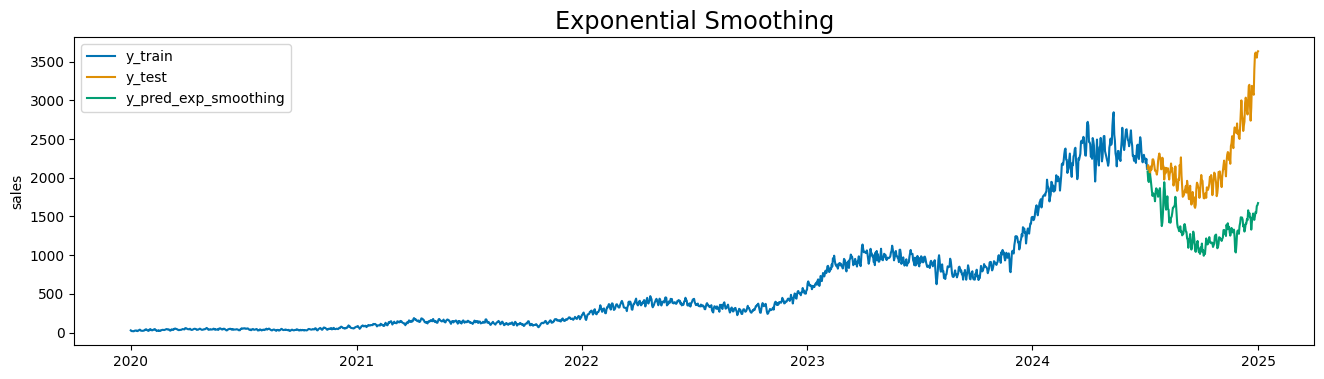

In [10]:
plot_series(y_train, y_test, y_pred_exp_smoothing, labels=["y_train", "y_test", "y_pred_exp_smoothing"], title="Exponential Smoothing", markers=[None]*3)

In [11]:
from sktime.forecasting.chronos import ChronosForecaster


model = ChronosForecaster("amazon/chronos-t5-tiny")
model.fit(y_train)

ChronosForecaster(model_path='amazon/chronos-t5-tiny')

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Chronos tiny'}, ylabel='sales'>)

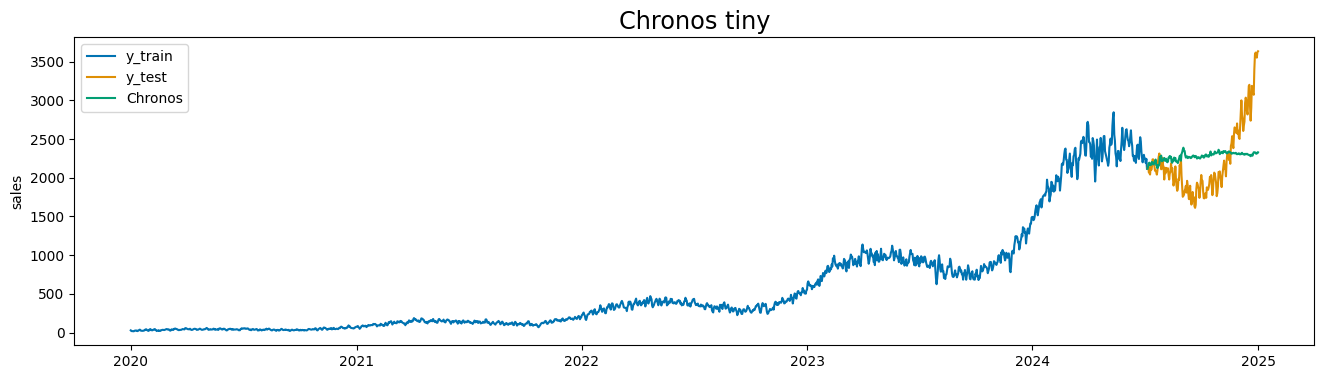

In [12]:
y_pred_chronos = model.predict(fh=y_test.index)
plot_series(y_train, y_test, y_pred_chronos, labels=["y_train", "y_test",  "Chronos"], title="Chronos tiny", markers=[None]*3)

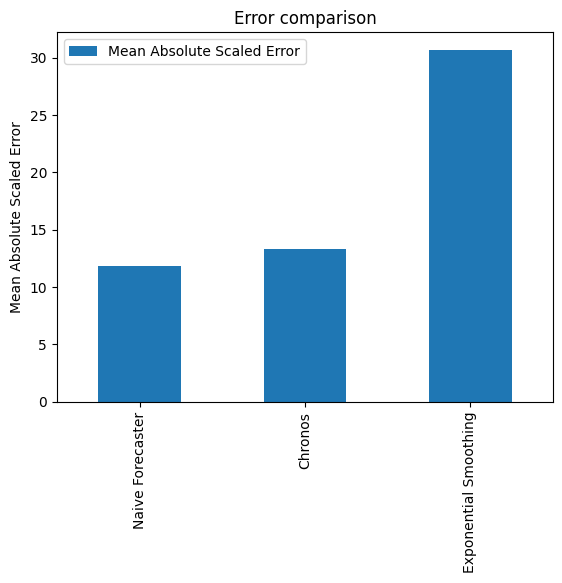

In [13]:
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanSquaredError,
    MeanAbsoluteScaledError,
)


metric = MeanAbsoluteScaledError()
error_baseline = metric(y_true=y_test, y_pred=y_pred, y_train=y_train)

error_chronos = metric(y_true=y_test, y_pred=y_pred_chronos, y_train=y_train)

error_exp_smoothing = metric(
    y_true=y_test, y_pred=y_pred_exp_smoothing, y_train=y_train
)

errors = pd.DataFrame(
    {
        "Naive Forecaster": error_baseline,
        "Chronos": error_chronos,
        "Exponential Smoothing": error_exp_smoothing,
    },
    index=["Mean Absolute Scaled Error"],
)

errors.T.plot.bar(title="Error comparison", ylabel="Mean Absolute Scaled Error")
plt.show()

## Transformations

Chronos fails with this dataset. Maybe we need some preprocessing?

### Transformations in sktime

* Transformations can be applied to the target variable `y` before fitting a model.
* Then, we inverse transform the predictions to get the original scale.

Common transformations include:
  - Logarithmic transformation
  - Differencing
  - Decomposition

### First transformation example: timeseries decomposition

1. **Trend**: Long-term movement in the data.
2. **Seasonality**: Regular patterns that repeat over time (e.g. weekly,
3. **Noise**: Random fluctuations in the data that cannot be explained by trend or seasonality.

In [14]:
from sktime.transformations.series.detrend import STLTransformer

transformer = STLTransformer(sp=365, return_components=True)
transformer.fit(y_train)

STLTransformer(return_components=True, sp=365)

In [15]:
y_decomposed = transformer.transform(y_train)
y_decomposed

,transformed,seasonal,trend,resid
2020-01-01,42.621319,-13.621319,56.389456,-13.768137
2020-01-02,37.799858,-17.799858,56.404288,-18.604429
2020-01-03,44.101022,-25.101022,56.419307,-12.318285
2020-01-04,40.215851,-21.215851,56.434515,-16.218664
2020-01-05,42.405556,-24.405556,56.449914,-14.044358
...,...,...,...,...
2024-07-01,2177.379173,68.620827,2138.475906,38.903267
2024-07-02,2141.305996,105.694004,2141.869969,-0.563973
2024-07-03,2151.673632,39.326368,2145.264647,6.408985
2024-07-04,2140.476003,103.523997,2148.659938,-8.183935


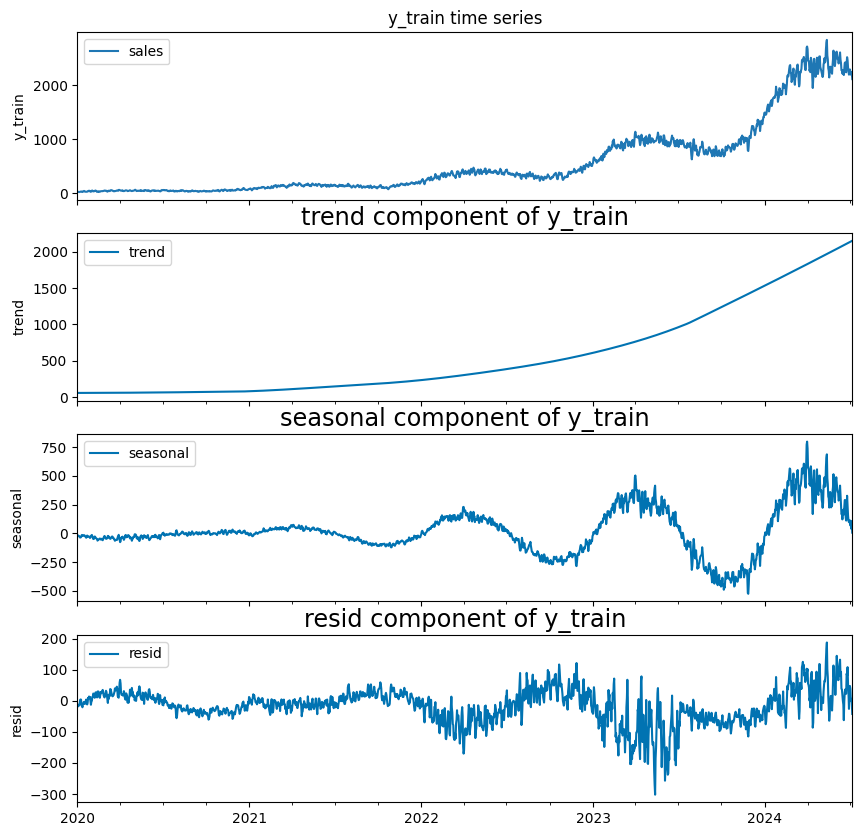

In [16]:
fig, axs = plt.subplots(nrows=4, figsize=(10, 10), sharex=True)

y_train.plot(ax=axs[0], title="y_train time series")
axs[0].set_ylabel("y_train")
axs[0].set_xlabel("date")
for i, component in enumerate(["trend", "seasonal", "resid"]):
    plot_series(y_decomposed[component], labels=[component], title=f"{component} component of y_train", markers=[None], ax=axs[i+1])
fig.show()

### Timeseries differencing

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Differenced time series'}, ylabel='sales'>)

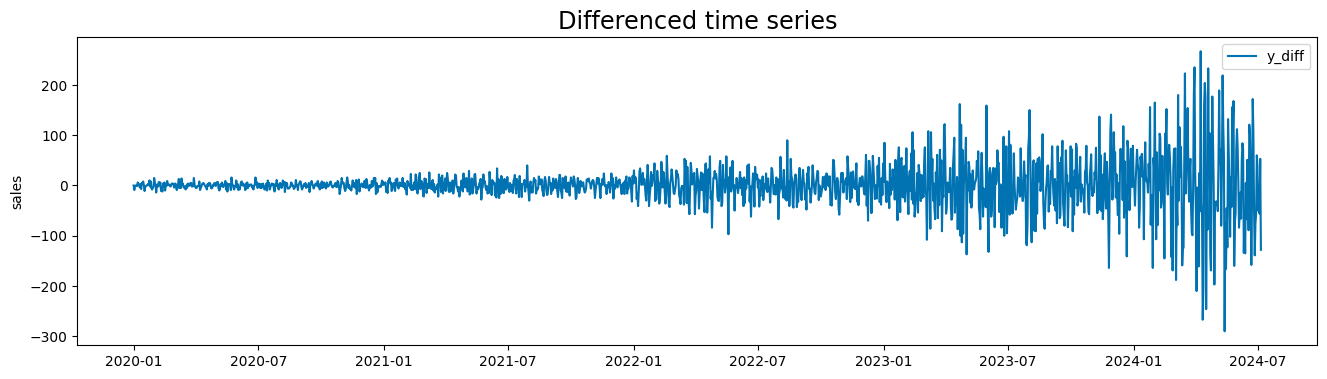

In [17]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer()
transformer.fit(y_train)
y_diff = transformer.transform(y_train)
plot_series(y_diff, labels=["y_diff"], title="Differenced time series", markers=[None])

### Composing transformations with forecast models

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'y_train, y_test and y_pred_diff time series'}, ylabel='sales'>)

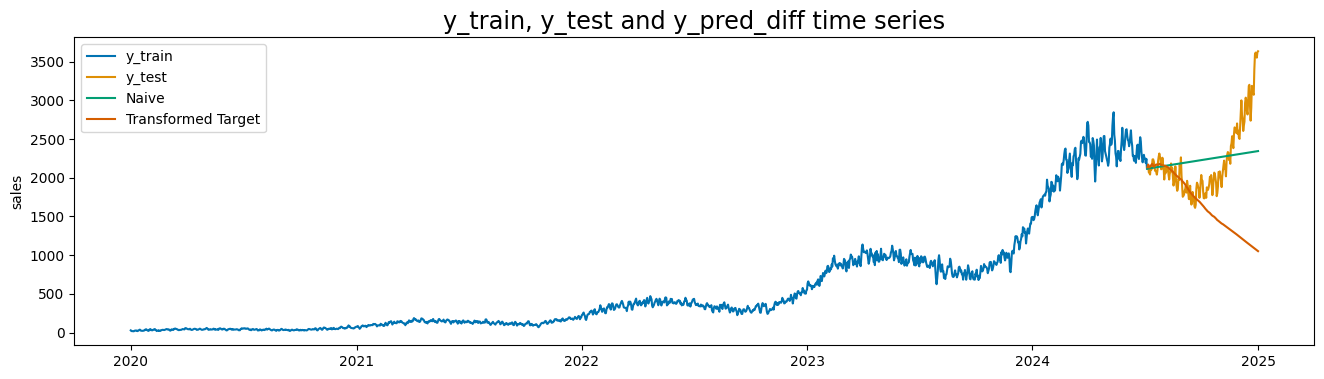

In [18]:
from sktime.forecasting.compose import TransformedTargetForecaster

model = TransformedTargetForecaster(
    steps=[
        ("differencer", Differencer()),
        ("forecaster", ChronosForecaster("amazon/chronos-t5-tiny", seed=42)),
    ]
)

model.fit(y_train)
y_pred_diff = model.predict(fh=y_test.index)
plot_series(y_train, y_test, y_pred, y_pred_diff, labels=["y_train", "y_test", "Naive", "Transformed Target"], title="y_train, y_test and y_pred_diff time series", markers=[None]*4)

In [19]:
model = Differencer() * ChronosForecaster("amazon/chronos-t5-tiny", seed=42)
model.fit(y_train)
y_pred_diff = model.predict(fh=y_test.index)


* Key components during fit
  * `y`: target variable
  * `X`: features (optional)
  * `fh`: forecasting horizon (optional)
* Key components during predict
  * `fh`: forecasting horizon (optional)
  * `X`: features (optional)
  

## Forecasting with exogenous data

In [20]:
X_train, X_test = dataset.load("X_train", "X_test")
X_train

,promo,macro_index
date,,
2020-01-01,0.06,98.196255
2020-01-02,0.10,99.613209
2020-01-03,0.00,103.098493
2020-01-04,0.02,101.083814
2020-01-05,0.02,102.708703
...,...,...
2024-07-01,0.06,98.750890
2024-07-02,0.02,103.205447
2024-07-03,0.10,100.525961


In [21]:
from sktime.registry import all_estimators

all_estimators("forecaster", filter_tags={"ignores-exogeneous-X": False}, as_dataframe=True).head(10)

,name,object
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,AutoREG,<class 'sktime.forecasting.auto_reg.AutoREG'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,BoxCoxBiasAdjustedForecaster,<class 'sktime.forecasting.boxcox_bias_adjuste...
7,CINNForecaster,<class 'sktime.forecasting.conditional_inverti...
8,ChronosForecaster,<class 'sktime.forecasting.chronos.ChronosFore...
9,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...


In [22]:
from sktime.forecasting.auto_reg import AutoREG


model_exog =  Differencer() * AutoREG(seasonal=True, period=365)
model_exog.fit(y_train, X=X_train)

TransformedTargetForecaster(steps=[Differencer(),
                                   AutoREG(period=365, seasonal=True)])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'AutoREG with exogenous variables'}, ylabel='sales'>)

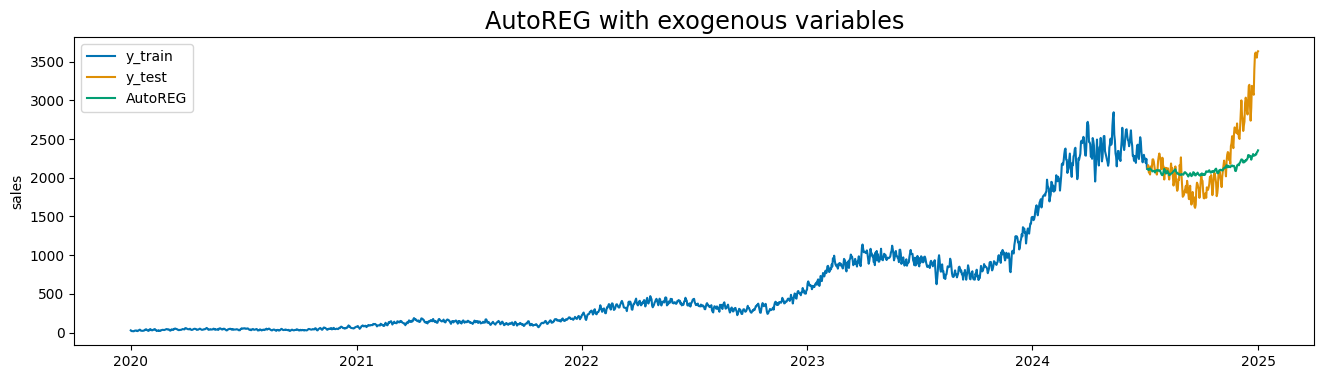

In [23]:
y_pred_exog = model_exog.predict(fh=y_test.index, X=X_test)
plot_series(y_train, y_test, y_pred_exog, labels=["y_train", "y_test", "AutoREG"], title="AutoREG with exogenous variables", markers=[None]*3)

## Advanced patterns: ensemble, stacking

In [24]:
from sktime.forecasting.compose import EnsembleForecaster


model_ensemble = EnsembleForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="drift")),
        ("exp_smoothing", ExponentialSmoothing(trend="add", seasonal="mul", sp=365)),
        ("chronos",Differencer() *  ChronosForecaster("amazon/chronos-t5-tiny")),
        ("autoregression",Differencer() *  AutoREG(seasonal=True, period=365)),
    ]
)

model_ensemble.fit(y_train, X=X_train)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


EnsembleForecaster(forecasters=[('naive', NaiveForecaster(strategy='drift')),
                                ('exp_smoothing',
                                 ExponentialSmoothing(seasonal='mul', sp=365,
                                                      trend='add')),
                                ('chronos',
                                 TransformedTargetForecaster(steps=[Differencer(),
                                                                    ChronosForecaster(model_path='amazon/chronos-t5-tiny')])),
                                ('autoregression',
                                 TransformedTargetForecaster(steps=[Differencer(),
                                                                    AutoREG(period=365,
                                                                            seasonal=True)]))])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Ensemble of Forecasters'}, ylabel='sales'>)

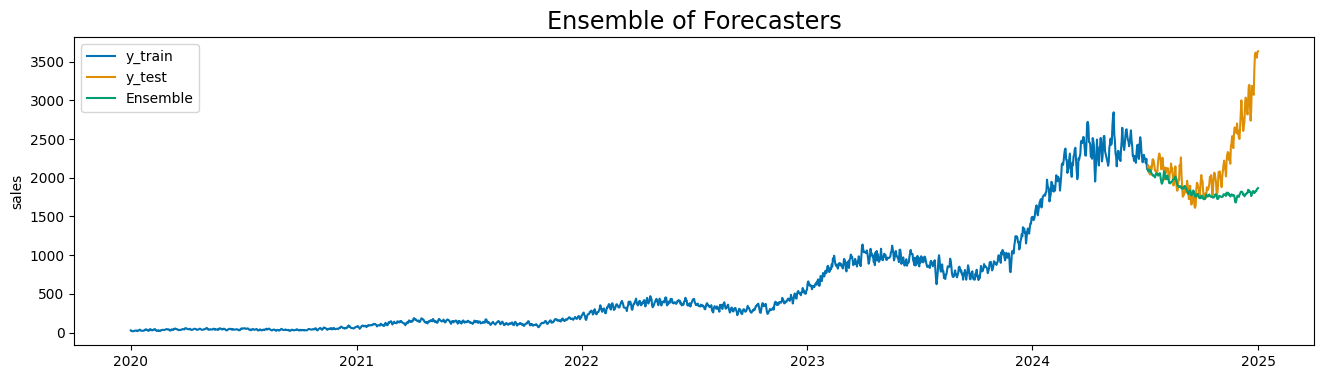

In [25]:
y_pred_ensemble = model_ensemble.predict(fh=y_test.index, X=X_test)
plot_series(y_train, y_test, y_pred_ensemble, labels=["y_train", "y_test", "Ensemble"], title="Ensemble of Forecasters", markers=[None]*3)

In [26]:
from sktime.forecasting.compose import StackingForecaster
from sklearn.ensemble import RandomForestRegressor


model_stacking = Differencer() * StackingForecaster(
    forecasters=[
        ("naive", NaiveForecaster()),
        ("exp_smoothing", ExponentialSmoothing(trend="add", seasonal="add", sp=365)),
        ("chronos", ChronosForecaster("amazon/chronos-t5-tiny")),
        ("autoregression",  AutoREG(seasonal=True, period=365)),
    ],
    regressor=RandomForestRegressor(),
)
model_stacking.fit(y_train, X=X_train, fh=y_test.index)

TransformedTargetForecaster(steps=[Differencer(),
                                   StackingForecaster(forecasters=[('naive',
                                                                    NaiveForecaster()),
                                                                   ('exp_smoothing',
                                                                    ExponentialSmoothing(seasonal='add',
                                                                                         sp=365,
                                                                                         trend='add')),
                                                                   ('chronos',
                                                                    ChronosForecaster(model_path='amazon/chronos-t5-tiny')),
                                                                   ('autoregression',
                                                                    AutoREG(period=365,
                                                                            seasonal=True))],
                                                      regressor=RandomForestRegressor())])

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Stacking Forecaster'}, ylabel='sales'>)

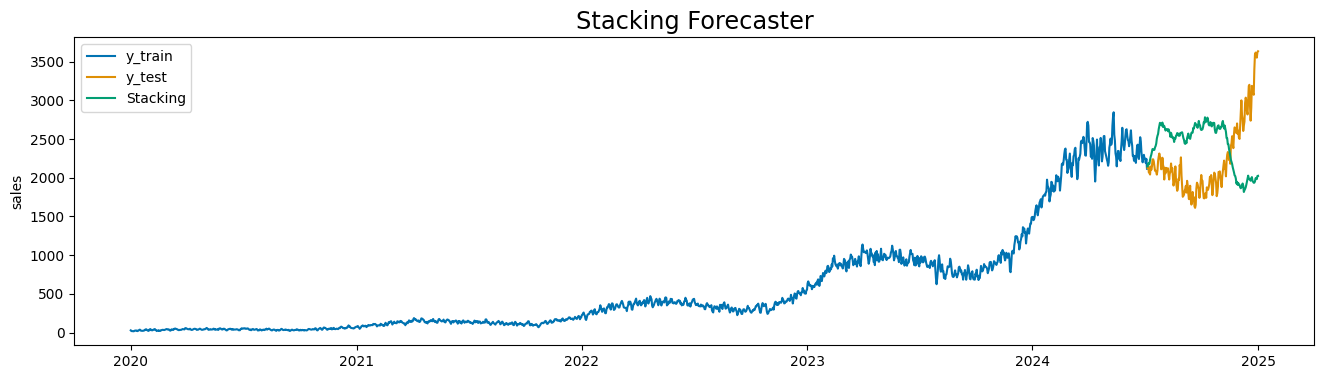

In [27]:
y_pred_stacking = model_stacking.predict(fh=y_test.index, X=X_test)
plot_series(y_train, y_test, y_pred_stacking, labels=["y_train", "y_test", "Stacking"], title="Stacking Forecaster", markers=[None]*3)

## Hyperparameter tuning & Automl

Tuners are first-class citizens in sktime, and can be used to optimize hyperparameters of models.

In [28]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import MultiplexForecaster
from sktime.split import ExpandingWindowSplitter, TemporalTrainTestSplitter

automl_model = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster("drift")),
        ("exp_smoothing", ExponentialSmoothing(trend="mul", seasonal="mul", sp=365)),
        ("autoregression", Differencer() * AutoREG(seasonal=True, period=365)),
    ],
    selected_forecaster="naive",  # Default forecaster
)

cv = ExpandingWindowSplitter(fh=list(range(1, 90)), initial_window=365*2, step_length=100)

tuner = ForecastingGridSearchCV(
    forecaster=automl_model,
    param_grid={
        "selected_forecaster": [
            "naive",
            "exp_smoothing",
            "autoregression"
        ],
    },
    cv=cv,
    scoring=MeanSquaredError(),
    error_score="raise",
)

tuner.fit(y_train, X=X_train)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/statsmodel

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19, 20,
                                                       21, 22, 23, 24, 25, 26,
                                                       27, 28, 29, 30, ...],
                                                   initial_window=730,
                                                   step_length=100),
                        error_score='raise',
                        forecaster=MultiplexForecaster(forecasters=[('naive',
                                                                     NaiveForecaster(strategy='drift')),
                                                                    ('exp_smoothing',
                                                                     ExponentialSmoothing(seasonal='mul',
                                                                                          sp=365,
                                                                                          trend='mul')),
                                                                    ('autoregression',
                                                                     TransformedTargetForecaster(steps=[Differencer(),
                                                                                                        AutoREG(period=365,
                                                                                                                seasonal=True)]))],
                                                       selected_forecaster='naive'),
                        param_grid={'selected_forecaster': ['naive',
                                                            'exp_smoothing',
                                                            'autoregression']},
                        scoring=MeanSquaredError())

In [29]:
tuner.cv_results_

,mean_test_MeanSquaredError,mean_fit_time,mean_pred_time,params,rank_test_MeanSquaredError
0,5.831908e+04,0.004715,0.001486,{'selected_forecaster': 'naive'},2.0
1,1.747921e+06,1.477404,0.005717,{'selected_forecaster': 'exp_smoothing'},3.0
2,4.532594e+04,0.081799,0.004551,{'selected_forecaster': 'autoregression'},1.0


In [30]:
tuner.best_forecaster_

MultiplexForecaster(forecasters=[('naive', NaiveForecaster(strategy='drift')),
                                 ('exp_smoothing',
                                  ExponentialSmoothing(seasonal='mul', sp=365,
                                                       trend='mul')),
                                 ('autoregression',
                                  TransformedTargetForecaster(steps=[Differencer(),
                                                                     AutoREG(period=365,
                                                                             seasonal=True)]))],
                    selected_forecaster='autoregression')

In [31]:
# Calling tuner predict redirects to the best forecaster
tuner.predict(fh=y_test.index, X=X_test)

,sales
2024-07-06,2112.25
2024-07-07,2100.00
2024-07-08,2096.50
2024-07-09,2112.50
2024-07-10,2117.25
...,...
2024-12-28,2280.25
2024-12-29,2279.75
2024-12-30,2306.55
2024-12-31,2314.15


## Next steps

* Fit and predict multiple timeseries
* Use Machine Learning regression models for forecasting
* Use Deep Learning models for forecasting